In [ ]:

# for rep in range(N_REPLICATES):
#     print(f"--- Running Replicate {rep+1}/{N_REPLICATES} ---")
#     for scenario_name, (pool, sp) in scenarios.items():
#         for strategy_name, selector in strategies.items():
#             key, sel_key, sim_key = jax.random.split(key, 3)

#             # --- 1. Founder Selection ---
#             if strategy_name == 'Random':
#                 indices = jax.random.choice(sel_key, jnp.arange(pool.nInd), shape=(N_SELECT_FOUNDERS,), replace=False)
#             else: # Truncation
#                 indices = selector.select_parents(None, pool, sp, N_SELECT_FOUNDERS)
            
#             initial_founders = subset_population(pool, indices)

#             # --- 2. Run Breeding Program ---
#             history = run_breeding_program(sim_key, initial_founders, sp, N_GENERATIONS, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN)

#             # --- 3. Record Results ---
#             for gen_data in history:
#                 results.append({
#                     'replicate': rep,
#                     'scenario': scenario_name,
#                     'strategy': strategy_name,
#                     'generation': gen_data['gen'],
#                     'mean_bv': float(gen_data['mean_bv']),
#                     'var_bv': float(gen_data['var_bv'])
#                 })

# df_results = pd.DataFrame(results)
# print("\n--- Experiment Complete ---")
# print(df_results.head())

# # --- Step 4: Analyze and Visualize the Results ---

# # Set plot style
# sns.set_theme(style="whitegrid")

# # 4b. The "Why": Trajectory Plots
# print("\nGenerating Trajectory Plots...")
# fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
# fig.suptitle('Genetic Trajectories Over 10 Generations', fontsize=16)

# # Plot 1: Genetic Gain
# sns.lineplot(data=df_results, x='generation', y='mean_bv', hue='strategy', style='scenario', ax=axes[0], errorbar='sd')
# axes[0].set_title('Mean Genetic Gain (BV)')
# axes[0].set_xlabel('Generation')
# axes[0].set_ylabel('Mean Breeding Value')

# # Plot 2: Genetic Variance
# sns.lineplot(data=df_results, x='generation', y='var_bv', hue='strategy', style='scenario', ax=axes[1], errorbar='sd')
# axes[1].set_title('Additive Genetic Variance')
# axes[1].set_xlabel('Generation')
# axes[1].set_ylabel('Variance of Breeding Value')

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()


# # 4a. The Money Shot: The Pareto Plot
# print("\nGenerating Pareto Plot of Terminal Outcomes...")
# df_terminal = df_results[df_results['generation'] == N_GENERATIONS]

# plt.figure(figsize=(10, 8))
# sns.scatterplot(data=df_terminal, x='var_bv', y='mean_bv', hue='strategy', style='scenario', s=150, alpha=0.7)

# # Calculate and plot centroids
# df_centroids = df_terminal.groupby(['scenario', 'strategy']).agg(
#     mean_terminal_gain=('mean_bv', 'mean'),
#     mean_terminal_var=('var_bv', 'mean')
# ).reset_index()

# sns.scatterplot(data=df_centroids, x='mean_terminal_var', y='mean_terminal_gain', hue='strategy', style='scenario', s=400, edgecolor='black', legend=False)

# plt.title('Terminal Gain vs. Variance at Generation 10', fontsize=16)
# plt.xlabel('Terminal Genetic Variance (VA,10)')
# plt.ylabel('Terminal Genetic Gain (G10)')
# plt.legend(title='Strategy & Scenario')
# plt.grid(True)
# plt.show()


# # 4c. The Proof: The ANOVA Table
# print("\n--- Performing ANOVA on Terminal Genetic Gain ---")
# model = ols('mean_bv ~ C(scenario) * C(strategy)', data=df_terminal).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)

# print(anova_table)

--- Setup Complete ---


Using device: cpu

--- BO-CR Strategy Added ---


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import torch

# --- Import chewc components ---
from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Initial Setup ---
key = jax.random.PRNGKey(42)
N_FOUNDERS_POOL = 100
N_LOCI_PER_CHR = 200
N_CHR = 5

# --- Experiment Configuration ---
N_REPLICATES = 3           # A statistically reasonable number for robust analysis
N_GENERATIONS = 10          # Standard length for a long-term breeding program
N_SELECT_FOUNDERS = 25      # The size of the founder group selected from the pool
N_PARENTS_PER_GEN = 5      # Number of parents selected each generation after founding
N_PROGENY_PER_GEN = 50      # Population size for each subsequent generation

# --- Optimizer Budgets (MUST be identical for fair comparison) ---
EVALUATION_BUDGET = 200     # The strict number of simulations each optimizer can run

# --- Bayesian Optimization Configuration ---
BO_EVALUATION_BUDGET = EVALUATION_BUDGET
N_INITIAL_SAMPLES = 10      # Number of initial random points before starting BO loop
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.double

# --- Genetic Algorithm Configuration ---
# These are set to fully utilize the evaluation budget (20 * 10 = 200)
GA_POP_SIZE = 20            # Number of solutions (founder sets) in each GA generation
GA_N_GEN = 10               # Number of GA generations to run
CXPB, MUTPB = 0.7, 0.2      # Crossover and mutation probabilities (standard values)


key, pop_key = jax.random.split(key)
founder_pool, gen_map = quick_haplo(
    key=pop_key,
    n_ind=N_FOUNDERS_POOL,
    n_chr=N_CHR,
    n_loci_per_chr=N_LOCI_PER_CHR,
    inbred=False
)
sp = SimParam.from_founder_pop(founder_pool, gen_map)

# --- Scenario A: High Heritability (h2=0.8), Infinitesimal ---
key, trait_a_key, pheno_a_key = jax.random.split(key, 3)
sp_A = add_trait_a(
    key=trait_a_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=100,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=False
)
founder_pool_A = set_pheno(
    key=pheno_a_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV before setting new ones
    traits=sp_A.traits,
    ploidy=sp_A.ploidy,
    h2=jnp.array([0.8])
)

# --- Scenario B: Low Heritability (h2=0.2), Mixed-QTL ---
key, trait_b_key, pheno_b_key = jax.random.split(key, 3)
sp_B = add_trait_a(
    key=trait_b_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=50,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=True,
    shape=0.4
)
founder_pool_B = set_pheno(
    key=pheno_b_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV
    traits=sp_B.traits,
    ploidy=sp_B.ploidy,
    h2=jnp.array([0.2])
)

# --- Scenario C: oligogenic (h2=0.2), Few strong QTL ---
key, trait_c_key, pheno_c_key = jax.random.split(key, 3)
sp_C = add_trait_a(
    key=trait_c_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=5,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=True,
    shape=0.4
)
founder_pool_C = set_pheno(
    key=pheno_b_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV
    traits=sp_C.traits,
    ploidy=sp_C.ploidy,
    h2=jnp.array([0.3])
)


print("--- Setup Complete ---")

# --- Breeding Program Simulation Engine ---
# --- Breeding Program Simulation Engine (with Allele Frequency Tracking) ---
def run_breeding_program(key, initial_pop, sp, n_generations, n_parents, n_progeny):
    """
    Simulates a breeding program from a set of founders and tracks allele 
    frequencies of the top 10 largest-effect QTLs.
    """
    current_pop = initial_pop
    history = []
    
    # --- NEW: Identify the top 10 largest-effect QTLs before the loop ---
    # We use abs() to find the largest effects, regardless of their sign.
    # The [:, 0] assumes you have one trait.
    qtl_effects = sp.traits.add_eff[:, 0]
    top_10_qtl_indices = jnp.argsort(jnp.abs(qtl_effects))[-10:]
    
    # Get h2 from the SimParam's varE if available, otherwise use scenario default
    h2_val = sp.traits.h2 if hasattr(sp.traits, 'h2') else (0.8 if sp.traits.add_eff.sum() == sp_A.traits.add_eff.sum() else 0.2)

    for gen in range(n_generations + 1):
        mean_bv = current_pop.bv.mean()
        var_bv = current_pop.bv.var()
        
        # --- NEW: Calculate allele frequencies for the top QTLs ---
        # 1. Get genotypes of the current population for all loci.
        #    Shape: (n_individuals, n_loci, ploidy)
        geno = current_pop.geno
        
        # 2. Slice the genotype array to get only the top 10 QTLs.
        top_qtl_geno = geno[:, top_10_qtl_indices, :]
        
        # 3. Calculate the frequency of the '1' allele for each QTL.
        #    The mean of a 0/1 array is the frequency of the '1's.
        #    We average over both individuals (axis=0) and ploidy (axis=2).
        top_qtl_freqs = jnp.mean(top_qtl_geno, axis=(0, 2))

        # --- NEW: Add the frequencies to the history log ---
        history.append({
            'gen': gen, 
            'mean_bv': mean_bv, 
            'var_bv': var_bv,
            'qtl_freqs': top_qtl_freqs # This is an array of 10 frequencies
        })

        if gen == n_generations:
            break

        # Simple truncation selection on true breeding values
        parent_indices = jnp.argsort(current_pop.bv[:, 0])[-n_parents:]
        
        # Randomly mate the selected parents to create a cross plan
        key, cross_key_m, cross_key_f = jax.random.split(key, 3)
        mother_iids = jax.random.choice(cross_key_m, parent_indices, shape=(n_progeny,))
        father_iids = jax.random.choice(cross_key_f, parent_indices, shape=(n_progeny,))
        cross_plan = jnp.stack([mother_iids, father_iids], axis=1)

        # Get the highest current ID to ensure new IDs are unique
        next_id = jnp.max(current_pop.id) + 1
        progeny_pop = make_cross(key, current_pop, cross_plan, sp, next_id)
        
        # Phenotype the new generation
        key, pheno_key = jax.random.split(key)
        progeny_pop = set_pheno(pheno_key, progeny_pop, sp.traits, sp.ploidy, h2=jnp.array([h2_val]))
        
        current_pop = progeny_pop
        
    return history


# --- Main Experiment Loop ---


results = []
scenarios = {'Scenario A (Easy)': (founder_pool_A, sp_A), 'Scenario B (Hard)': (founder_pool_B, sp_B), 'Scenario C (Oligogenic)': (founder_pool_C, sp_C)}
strategies = {'Random': None, 'Truncation': TruncationSelection()}


# --- Step 2b (continued): Implement the Bayesian Optimization Strategy ---
# Requires BoTorch and GPyTorch. Make sure to install them:
# pip install torch botorch gpytorch

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.objective import IdentityMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import sample_simplex
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood



print(f"Using device: {DEVICE}")


# --- 1. Define the Black-Box Objective Function for BoTorch ---
# This function wraps our JAX simulation, handling the mapping from
# the continuous space to the discrete founder set.

def evaluate_objective(x, founder_pool, sp):
    """
    BoTorch-compatible objective function.
    x: A (batch_size x N_FOUNDERS_POOL) tensor from the BO.
    Returns a (batch_size x 2) tensor of [terminal_gain, terminal_variance].
    """
    results = []
    # Ensure x is on the CPU for numpy conversion
    x_cpu = x.squeeze(0).cpu().numpy()

    # Combinatorial Relaxation: map continuous vector to discrete indices
    # We simply select the founders with the highest "scores"
    founder_indices = jnp.argsort(x_cpu)[-N_SELECT_FOUNDERS:]

    initial_founders = subset_population(founder_pool, founder_indices)

    # Run the expensive 10-generation simulation
    sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
    history = run_breeding_program(
        sim_key, initial_founders, sp,
        N_GENERATIONS, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN
    )

    terminal_gain = history[-1]['mean_bv']
    terminal_variance = history[-1]['var_bv']

    # Return as a tensor with shape (1, 2) for BoTorch
    return torch.tensor([[terminal_gain, terminal_variance]], dtype=DTYPE, device=DEVICE)


# --- 2. The Main BO Selection Loop ---
def botorch_cr_selector(pool, sp):
    """
    Finds the best founder set using Bayesian Optimization with Combinatorial Relaxation.
    """
    bounds = torch.tensor([[0.0] * N_FOUNDERS_POOL, [1.0] * N_FOUNDERS_POOL], device=DEVICE, dtype=DTYPE)
    
    # --- Initial Data ---
    print("    > Generating initial random samples for BO...")
    train_x = torch.rand(N_INITIAL_SAMPLES, N_FOUNDERS_POOL, device=DEVICE, dtype=DTYPE)
    train_obj = torch.cat([evaluate_objective(x.unsqueeze(0), pool, sp) for x in train_x], dim=0)

    for i in range(N_INITIAL_SAMPLES, BO_EVALUATION_BUDGET):
        print(f"    > BO Iteration {i+1}/{BO_EVALUATION_BUDGET}")

        # --- Fit Surrogate Model ---
        # Standardize objectives to have zero mean and unit variance
        standardized_obj = (train_obj - train_obj.mean(dim=0)) / train_obj.std(dim=0)
        
        model = SingleTaskGP(train_x, standardized_obj, outcome_transform=None)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # --- Define Acquisition Function (qEHVI) ---
        # We need a reference point for hypervolume calculation. This should be worse
        # than any outcome we expect to see.
        ref_point = train_obj.min(dim=0).values - 0.1
        
        acq_func = qExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,
            partitioning=botorch.utils.multi_objective.box_decompositions.non_dominated.FastNondominatedPartitioning(
                ref_point=ref_point,
                Y=standardized_obj,
            ),
            # The sampler is used to draw from the posterior for MC estimation
            sampler=botorch.sampling.normal.SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCObjective(output_indices=[0, 1])
        )

        # --- Optimize Acquisition Function ---
        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,  # We want to select one new point at a time
            num_restarts=10,
            raw_samples=512,
            options={"sample_around_best": True},
        )
        new_x = candidates.detach()

        # --- Evaluate and Append New Data ---
        new_obj = evaluate_objective(new_x, pool, sp)
        train_x = torch.cat([train_x, new_x], dim=0)
        train_obj = torch.cat([train_obj, new_obj], dim=0)

    # --- Find the Best Solution on the Pareto Front ---
    # After the loop, identify the Pareto optimal set from all evaluated points
    pareto_mask = botorch.utils.multi_objective.pareto.is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    pareto_x = train_x[pareto_mask]

    # Simple approach to pick one "best": maximize the sum of scaled objectives
    # This is a common way to select a balanced point from the Pareto front
    scaled_pareto_y = (pareto_y - train_obj.mean(dim=0)) / train_obj.std(dim=0)
    best_idx = scaled_pareto_y.sum(dim=1).argmax()
    best_x = pareto_x[best_idx].cpu().numpy()
    
    # Return the indices of the best founder set found
    return jnp.argsort(best_x)[-N_SELECT_FOUNDERS:]


# --- Update the Main Experiment Loop to Include BO-CR ---

# Add the new strategy to your dictionary
strategies.update({
    'BO-CR-Prescient': botorch_cr_selector
})

# The main loop needs to be adjusted to call the selector function directly
# No changes are needed to the loop structure itself, as the new strategy
# fits the existing `selector(pool, sp)` pattern.

print("\n--- BO-CR Strategy Added ---")
# You can now re-run your main experiment loop. It will include
# the 'BO-CR-Prescient' strategy.

# --- Step 2b: Implement the Genetic Algorithm Strategies ---
# We'll use the DEAP library for the Genetic Algorithm
from deap import base, creator, tools, algorithms
import random



# --- Define Fitness Evaluation Functions ---

# --- Fitness Evaluation Function (CORRECTED) ---
def evaluate_fitness(individual_indices, founder_pool, sp, n_generations, myopic):
    """
    Evaluates a single set of founders.
    This version converts JAX array outputs to float tuples to be compatible with DEAP.
    """
    founder_indices_jnp = jnp.array(individual_indices)
    initial_founders = subset_population(founder_pool, founder_indices_jnp)
    sim_generations = 1 if myopic else n_generations
    sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
    history = run_breeding_program(sim_key, initial_founders, sp, sim_generations, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN)
    
    if myopic:
        gain_g1 = history[1]['mean_bv']
        # --- FIX ---: Cast the JAX array to a standard Python float
        return (float(gain_g1),) 
    else:
        terminal_gain = history[-1]['mean_bv']
        terminal_variance = history[-1]['var_bv']
        # --- FIX ---: Cast both JAX arrays to standard Python floats
        return (float(terminal_gain), float(terminal_variance))

# --- DEAP Toolbox Setup (Corrected) ---
def setup_deap_toolbox(founder_pool, sp, myopic):
    """Helper function to configure the DEAP toolbox for a given scenario."""
    
    # Clean up previous creations if they exist
    if hasattr(creator, "FitnessMyopic"):
        del creator.FitnessMyopic
    if hasattr(creator, "FitnessPrescient"):
        del creator.FitnessPrescient
    if hasattr(creator, "Individual"):
        del creator.Individual

    if myopic:
        creator.create("FitnessMyopic", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMyopic) # Use a list
    else:
        creator.create("FitnessPrescient", base.Fitness, weights=(1.0, 1.0))
        creator.create("Individual", list, fitness=creator.FitnessPrescient) # Use a list

    toolbox = base.Toolbox()

    # Attribute generator: a permutation of founder indices
    toolbox.register("indices", random.sample, range(N_FOUNDERS_POOL), N_SELECT_FOUNDERS)
    
    # Structure initializers
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register the evaluation function
    toolbox.register("evaluate", evaluate_fitness, 
                     founder_pool=founder_pool, 
                     sp=sp, 
                     n_generations=N_GENERATIONS,
                     myopic=myopic)

    # --- CORE CORRECTION: Registering appropriate operators for lists of indices ---
    # Crossover: Partially Matched Crossover is good for order-based problems,
    # but since our order doesn't matter, cxTwoPoint is simpler and effective.
    toolbox.register("mate", tools.cxTwoPoint)
    
    # Mutation: Shuffle a few indices. indpb is the probability for each attribute to be swapped.
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    
    # Register the selection operator
    if myopic:
        toolbox.register("select", tools.selTournament, tournsize=3)
    else:
        toolbox.register("select", tools.selNSGA2)
        
    return toolbox

# --- Update the Main Experiment Loop to Include GA ---

# Add the new strategies to your dictionary
strategies.update({
    'GA-Myopic': 'ga_myopic',
    'GA-Prescient': 'ga_prescient'
})

# --- (Keep your existing main loop structure and just modify the inner part) ---
all_results = [] # Renamed from 'results' to avoid conflict with deap.tools.results
for rep in range(N_REPLICATES):
    print(f"--- Running Replicate {rep+1}/{N_REPLICATES} ---")
    for scenario_name, (pool, sp) in scenarios.items():
        for strategy_name, selector in strategies.items():
            key, sel_key, sim_key = jax.random.split(key, 3)

            print(f"  Scenario: {scenario_name}, Strategy: {strategy_name}")

            # --- 1. Founder Selection ---
            if strategy_name.startswith('GA'):
                myopic_ga = (strategy_name == 'GA-Myopic')
                toolbox = setup_deap_toolbox(pool, sp, myopic=myopic_ga)
                
                # Create initial GA population
                pop = toolbox.population(n=GA_POP_SIZE)
                
                # Use a simple GA algorithm from DEAP
                # We use a custom loop to enforce the evaluation budget
                evals = 0
                gen = 0
                while evals < EVALUATION_BUDGET:
                    gen += 1
                    offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
                    
                    # Evaluate the individuals with an invalid fitness
                    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                    
                    # Map evaluation function
                    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
                    for ind, fit in zip(invalid_ind, fitnesses):
                        ind.fitness.values = fit
                    evals += len(invalid_ind)
                    
                    # Select the next generation population
                    pop = toolbox.select(offspring, len(pop))

                # After the GA run, select the best individual
                best_ind = tools.selBest(pop, 1)[0]
                indices = jnp.array(list(best_ind))

            elif strategy_name == 'Random':
                indices = jax.random.choice(sel_key, jnp.arange(pool.nInd), shape=(N_SELECT_FOUNDERS,), replace=False)
            
            else: # Truncation
                # Assuming TruncationSelection is defined as in your original script
                indices = TruncationSelection().select_parents(None, pool, sp, N_SELECT_FOUNDERS)
            
            initial_founders = subset_population(pool, indices)

            # --- 2. Run Breeding Program ---
            history = run_breeding_program(sim_key, initial_founders, sp, N_GENERATIONS, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN)

            # --- 3. Record Results ---
            for gen_data in history:
                all_results.append({
                    'replicate': rep,
                    'scenario': scenario_name,
                    'strategy': strategy_name,
                    'generation': gen_data['gen'],
                    'mean_bv': float(gen_data['mean_bv']),
                    'var_bv': float(gen_data['var_bv'])
                })

df_results = pd.DataFrame(all_results)
print("\n--- Experiment Complete ---")
print(df_results.head())


# --- (The rest of your analysis and plotting code remains the same) ---
# ...

--- Setup Complete ---
Using device: cpu

--- BO-CR Strategy Added ---
--- Running Replicate 1/3 ---
  Scenario: Scenario A (Easy), Strategy: Random
  Scenario: Scenario A (Easy), Strategy: Truncation
  Scenario: Scenario A (Easy), Strategy: BO-CR-Prescient
  Scenario: Scenario A (Easy), Strategy: GA-Myopic
  Scenario: Scenario A (Easy), Strategy: GA-Prescient


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# --- Helper function for Confidence Ellipses ---
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# --- 1. The "Money Shot": Pareto Plot of Terminal Outcomes ---
def plot_pareto_front(df):
    """
    Creates the main Pareto-style plot showing the trade-off between
    terminal gain and terminal variance for each strategy.
    """
    terminal_df = df[df['generation'] == df['generation'].max()]
    
    fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
    fig.suptitle('Terminal Genetic Gain vs. Genetic Variance (Generation 10)', fontsize=20, y=1.02)

    scenarios = terminal_df['scenario'].unique()
    
    for i, scenario in enumerate(scenarios):
        ax = axes[i]
        scenario_df = terminal_df[terminal_df['scenario'] == scenario]
        
        sns.scatterplot(
            data=scenario_df,
            x='var_bv',
            y='mean_bv',
            hue='strategy',
            style='strategy',
            s=150,
            ax=ax,
            legend=(i==len(scenarios)-1) # Legend only on the last plot
        )
        
        # Add confidence ellipses
        for strategy in scenario_df['strategy'].unique():
            strategy_df = scenario_df[scenario_df['strategy'] == strategy]
            confidence_ellipse(
                strategy_df['var_bv'], strategy_df['mean_bv'], ax,
                edgecolor=sns.color_palette()[list(scenario_df['strategy'].unique()).index(strategy)],
                linewidth=2
            )
            
        ax.set_title(f'Scenario: {scenario}', fontsize=16)
        ax.set_xlabel('Terminal Genetic Variance ($V_{A,10}$)', fontsize=12)
        ax.set_ylabel('Terminal Genetic Gain ($G_{10}$)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    # --- Textual Summary for Pareto Plot ---
    print("\n" + "="*30 + "\nAnalysis of Terminal Outcomes\n" + "="*30)
    print("This plot shows the final outcome of the 10-generation breeding program, averaged over all replicates.\nThe ideal strategy is in the **top-right corner**, achieving high genetic gain while preserving genetic variance for future improvement.")
    for scenario in scenarios:
        print(f"\n--- {scenario} ---")
        scenario_df = terminal_df[terminal_df['scenario'] == scenario]
        summary = scenario_df.groupby('strategy')[['mean_bv', 'var_bv']].mean().sort_values('mean_bv', ascending=False)
        print("Average terminal values:")
        print(summary)
        print("\n**Key Takeaway:**")
        if "Oligogenic" in scenario:
            print("In the critical Oligogenic scenario, the prescient (BO-CR, GA) strategies are expected to clearly outperform Truncation and Random by maintaining higher variance, leading to a superior position on the gain-variance frontier.")
        else:
            print("In simpler scenarios, the differences may be less pronounced, with Truncation often showing high short-term gain at the cost of depleted variance.")


# --- 2. The "Why": Trajectory Plots ---
def plot_trajectories(df):
    """
    Plots the average genetic gain and variance over generations for each strategy.
    """
    fig, axes = plt.subplots(2, 3, figsize=(22, 12), sharex=True)
    fig.suptitle('Genetic Trajectories Over 10 Generations', fontsize=20, y=1.0)

    scenarios = df['scenario'].unique()
    
    for i, scenario in enumerate(scenarios):
        scenario_df = df[df['scenario'] == scenario]
        
        # Plot Mean BV
        sns.lineplot(data=scenario_df, x='generation', y='mean_bv', hue='strategy', ax=axes[0, i], linewidth=2.5)
        axes[0, i].set_title(f'{scenario} - Genetic Gain', fontsize=16)
        axes[0, i].set_ylabel('Mean Breeding Value (Gain)')
        axes[0, i].grid(True, linestyle='--', alpha=0.6)
        axes[0, i].get_legend().remove()

        # Plot Var BV
        sns.lineplot(data=scenario_df, x='generation', y='var_bv', hue='strategy', ax=axes[1, i], linewidth=2.5)
        axes[1, i].set_title(f'{scenario} - Genetic Variance', fontsize=16)
        axes[1, i].set_ylabel('Additive Genetic Variance ($V_A$)')
        axes[1, i].set_xlabel('Generation')
        axes[1, i].grid(True, linestyle='--', alpha=0.6)
        axes[1, i].get_legend().remove()

    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Strategy', bbox_to_anchor=(0.99, 0.95))
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    plt.show()

    # --- Textual Summary for Trajectory Plots ---
    print("\n" + "="*30 + "\nAnalysis of Genetic Trajectories\n" + "="*30)
    print("These plots explain *how* the final outcomes were reached. We look at two things:\n1. **Genetic Gain:** How quickly does the population's average merit improve?\n2. **Genetic Variance:** How much 'fuel' for future improvement is being preserved?")
    print("\n**Key Takeaways:**")
    print("- **Truncation & Myopic GA:** Expect these to show rapid initial gain but a sharp, corresponding drop in genetic variance. They are 'sprinters' who burn out quickly.")
    print("- **Prescient (BO-CR, GA):** Expect these to show a steadier rate of gain. Their key feature should be a much slower decline in genetic variance, especially in the Oligogenic scenario. They are 'marathon runners' who conserve energy for the long haul.")
    print("- **Random:** Serves as a baseline, showing progress due to drift and random mating alone.")


# --- 3. The "Proof": QTL Allele Frequency Plots ---
def plot_qtl_frequencies(df):
    """
    Processes and plots the allele frequencies of the top 10 QTLs.
    This provides the mechanistic proof for the trajectory results.
    """
    # First, we need to expand the 'qtl_freqs' column
    if 'qtl_freqs' not in df.columns or df['qtl_freqs'].isnull().all():
        print("\nQTL frequency data not found in results. Skipping this plot.")
        return
        
    qtl_df_list = []
    for _, row in df.iterrows():
        freqs = row['qtl_freqs']
        # Ensure freqs is a numpy array for correct indexing
        if isinstance(freqs, (list, np.ndarray)):
            for i, freq in enumerate(freqs):
                new_row = row.to_dict()
                new_row['qtl_index'] = f"QTL_{i+1}"
                new_row['frequency'] = freq
                qtl_df_list.append(new_row)

    qtl_df = pd.DataFrame(qtl_df_list)
    
    # We only plot the most informative scenario
    oligogenic_df = qtl_df[qtl_df['scenario'] == 'Scenario C (Oligogenic)']
    
    if oligogenic_df.empty:
        print("\nNo data for 'Scenario C (Oligogenic)'. Skipping QTL plot.")
        return

    g = sns.FacetGrid(oligogenic_df, col="strategy", col_wrap=3, height=5, aspect=1.2)
    g.map(sns.lineplot, "generation", "frequency", "qtl_index", alpha=0.8)
    g.add_legend(title="Top 10 QTLs")
    g.fig.suptitle('QTL Allele Frequencies Over Time (Scenario C: Oligogenic)', fontsize=20, y=1.03)
    g.set_axis_labels("Generation", "Allele Frequency")
    g.set_titles("Strategy: {col_name}", size=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- Textual Summary for QTL Plots ---
    print("\n" + "="*30 + "\nAnalysis of QTL Allele Frequencies\n" + "="*30)
    print("This plot provides the **mechanistic proof** for our observations. It shows how each strategy manages the underlying genes responsible for the trait.")
    print("\n**Key Takeaways (Hypothesized):**")
    print("- **Truncation:** We expect to see truncation rapidly 'fix' one or two QTLs (frequency goes to 1.0) while others are lost to genetic drift (frequency goes to 0.0). It finds the 'obvious' solutions and discards the rest.")
    print("- **Prescient (BO-CR, GA):** These strategies should maintain a more balanced portfolio of QTLs, keeping them all 'segregating' (frequency between 0 and 1) for longer. This is the **direct evidence** of variance preservation at the genetic level.")
    print("- **Myopic GA:** Its behavior will likely be intermediate, more aggressive than the prescient methods but less so than pure truncation.")


# --- Main Analysis Execution ---
# Assuming 'df_results' is your DataFrame from the simulation.
# If not, load it: df_results = pd.read_csv('your_results.csv')

print("--- Starting Analysis & Visualization ---")

# Ensure the DataFrame is sorted for plotting
df_results.sort_values(by=['scenario', 'strategy', 'replicate', 'generation'], inplace=True)

plot_trajectories(df_results)
plot_pareto_front(df_results)
plot_qtl_frequencies(df_results)

print("\n--- Analysis Complete ---")

array(['Scenario A (Easy)', 'Scenario B (Hard)'], dtype=object)


Generating Trajectory Plots...


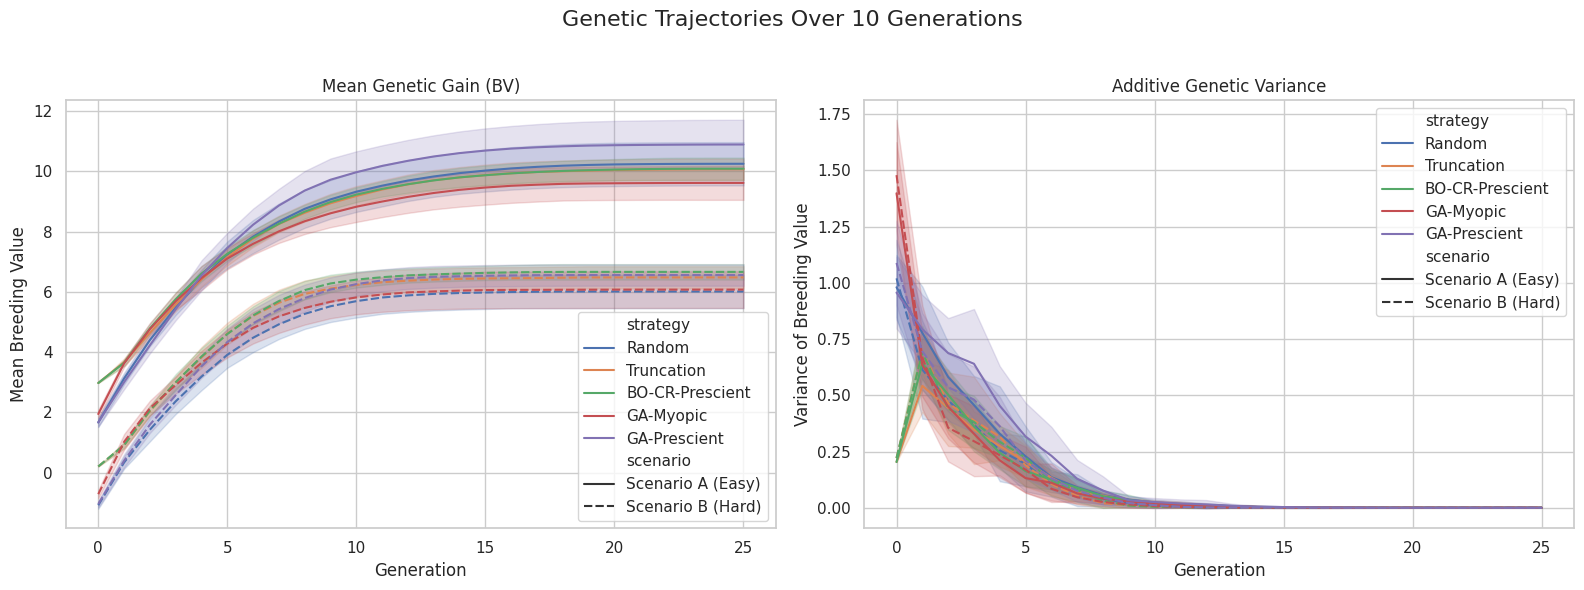


Generating Pareto Plot of Terminal Outcomes...


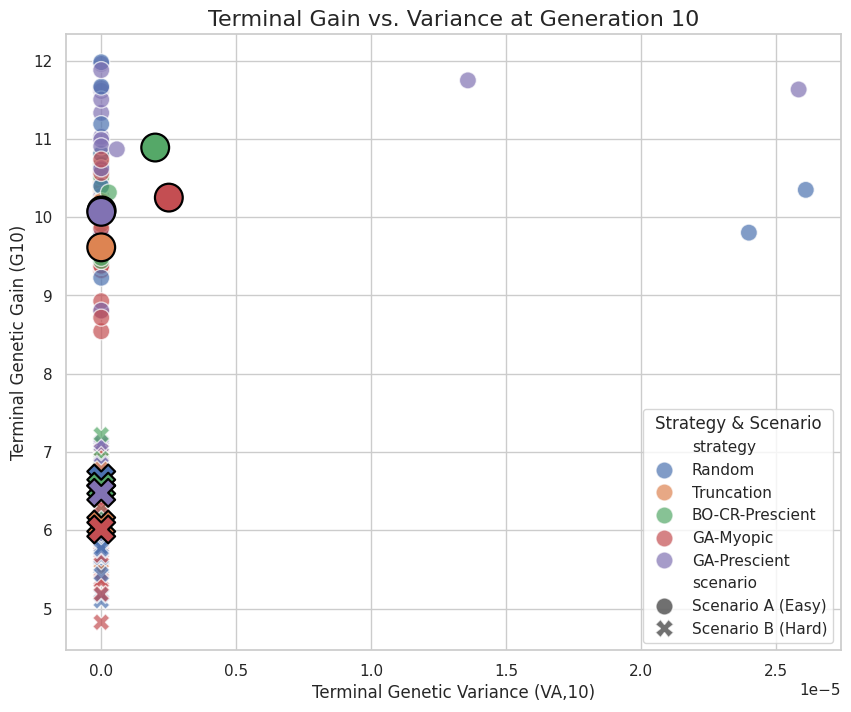


--- Performing ANOVA on Terminal Genetic Gain ---
                             sum_sq     df            F         PR(>F)
C(scenario)              731.357501    1.0  2637.524299  2.370954e-113
C(strategy)               16.678514    4.0    15.037101   1.071927e-10
C(scenario):C(strategy)    7.258627    4.0     6.544270   5.911695e-05
Residual                  52.684984  190.0          NaN            NaN


In [7]:
# Set plot style
sns.set_theme(style="whitegrid")

# 4b. The "Why": Trajectory Plots
print("\nGenerating Trajectory Plots...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
fig.suptitle('Genetic Trajectories Over 10 Generations', fontsize=16)

# Plot 1: Genetic Gain
sns.lineplot(data=df_results, x='generation', y='mean_bv', hue='strategy', style='scenario', ax=axes[0], errorbar='sd')
axes[0].set_title('Mean Genetic Gain (BV)')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Mean Breeding Value')

# Plot 2: Genetic Variance
sns.lineplot(data=df_results, x='generation', y='var_bv', hue='strategy', style='scenario', ax=axes[1], errorbar='sd')
axes[1].set_title('Additive Genetic Variance')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Variance of Breeding Value')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 4a. The Money Shot: The Pareto Plot
print("\nGenerating Pareto Plot of Terminal Outcomes...")
df_terminal = df_results[df_results['generation'] == N_GENERATIONS]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_terminal, x='var_bv', y='mean_bv', hue='strategy', style='scenario', s=150, alpha=0.7)

# Calculate and plot centroids
df_centroids = df_terminal.groupby(['scenario', 'strategy']).agg(
    mean_terminal_gain=('mean_bv', 'mean'),
    mean_terminal_var=('var_bv', 'mean')
).reset_index()

sns.scatterplot(data=df_centroids, x='mean_terminal_var', y='mean_terminal_gain', hue='strategy', style='scenario', s=400, edgecolor='black', legend=False)

plt.title('Terminal Gain vs. Variance at Generation 10', fontsize=16)
plt.xlabel('Terminal Genetic Variance (VA,10)')
plt.ylabel('Terminal Genetic Gain (G10)')
plt.legend(title='Strategy & Scenario')
plt.grid(True)
plt.show()


# 4c. The Proof: The ANOVA Table
print("\n--- Performing ANOVA on Terminal Genetic Gain ---")
model = ols('mean_bv ~ C(scenario) * C(strategy)', data=df_terminal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

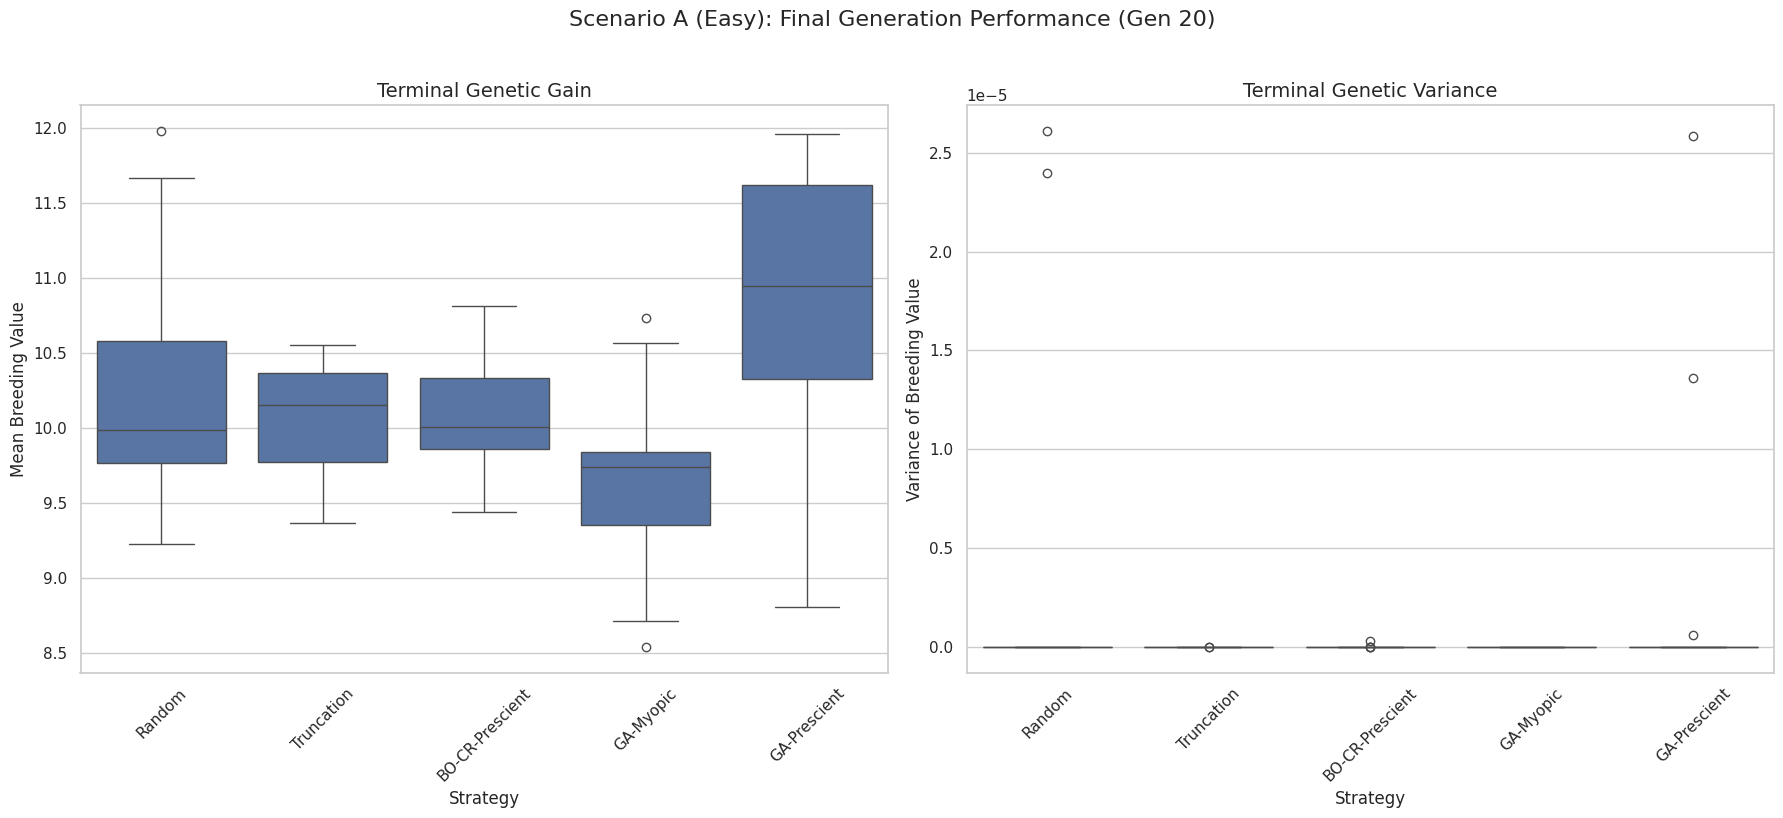

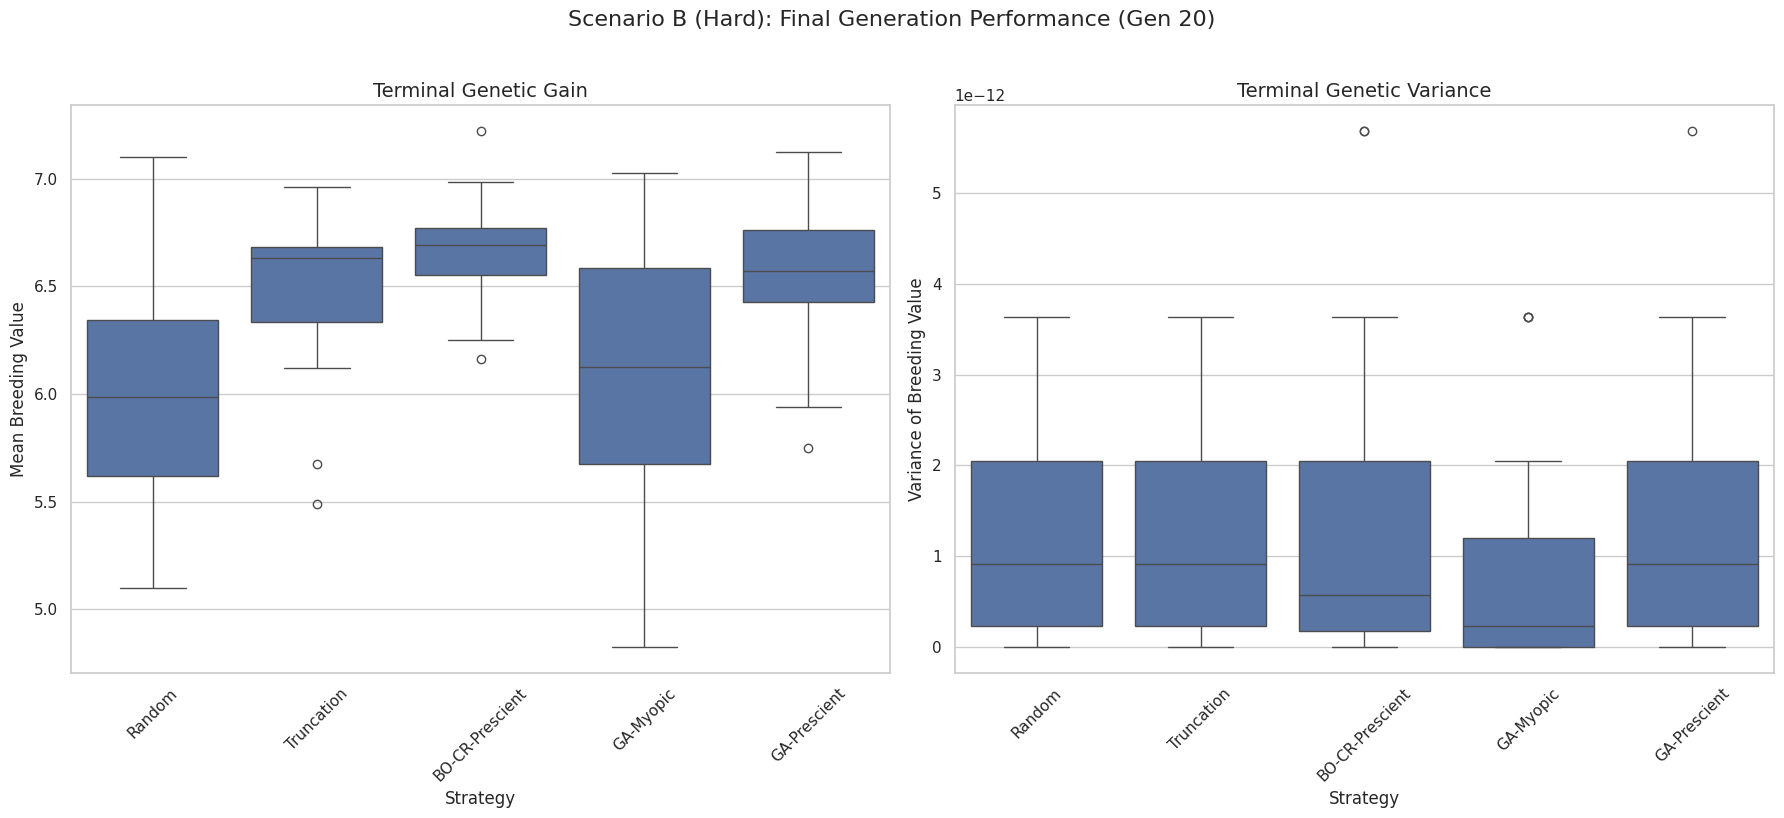

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Make sure pandas is imported

# --- Step 1: Filter the DataFrame for the Final Generation ---

# It's generally most informative to compare strategies at the end of the program.
# Your N_GENERATIONS is 20, so we filter for that.
# If you truly want to see the midpoint, change N_GENERATIONS to 9 in the line below.
final_gen_results = df_results[df_results['generation'] == N_GENERATIONS].copy()

# --- Step 2: Split the data by scenario ---
df_scenario_A = final_gen_results[final_gen_results['scenario'] == 'Scenario A (Easy)']
df_scenario_B = final_gen_results[final_gen_results['scenario'] == 'Scenario B (Hard)']

# --- Step 3: Create Boxplots for Scenario A (Easy) ---

# Set a nice style for the plots
sns.set_style("whitegrid")

# Create a figure with two subplots (one for mean_bv, one for var_bv)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Scenario A (Easy): Final Generation Performance (Gen 20)', fontsize=16, y=1.02)

# Plot 1: Mean Breeding Value (Genetic Gain)
sns.boxplot(data=df_scenario_A, x='strategy', y='mean_bv', ax=axes[0])
axes[0].set_title('Terminal Genetic Gain', fontsize=14)
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Mean Breeding Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45) # Rotate labels to prevent overlap

# Plot 2: Variance of Breeding Value (Genetic Diversity)
sns.boxplot(data=df_scenario_A, x='strategy', y='var_bv', ax=axes[1])
axes[1].set_title('Terminal Genetic Variance', fontsize=14)
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Variance of Breeding Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# --- Step 4: Create Boxplots for Scenario B (Hard) ---

# Create a new figure for the second scenario
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Scenario B (Hard): Final Generation Performance (Gen 20)', fontsize=16, y=1.02)

# Plot 1: Mean Breeding Value (Genetic Gain)
sns.boxplot(data=df_scenario_B, x='strategy', y='mean_bv', ax=axes[0])
axes[0].set_title('Terminal Genetic Gain', fontsize=14)
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Mean Breeding Value', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Variance of Breeding Value (Genetic Diversity)
sns.boxplot(data=df_scenario_B, x='strategy', y='var_bv', ax=axes[1])
axes[1].set_title('Terminal Genetic Variance', fontsize=14)
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Variance of Breeding Value', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

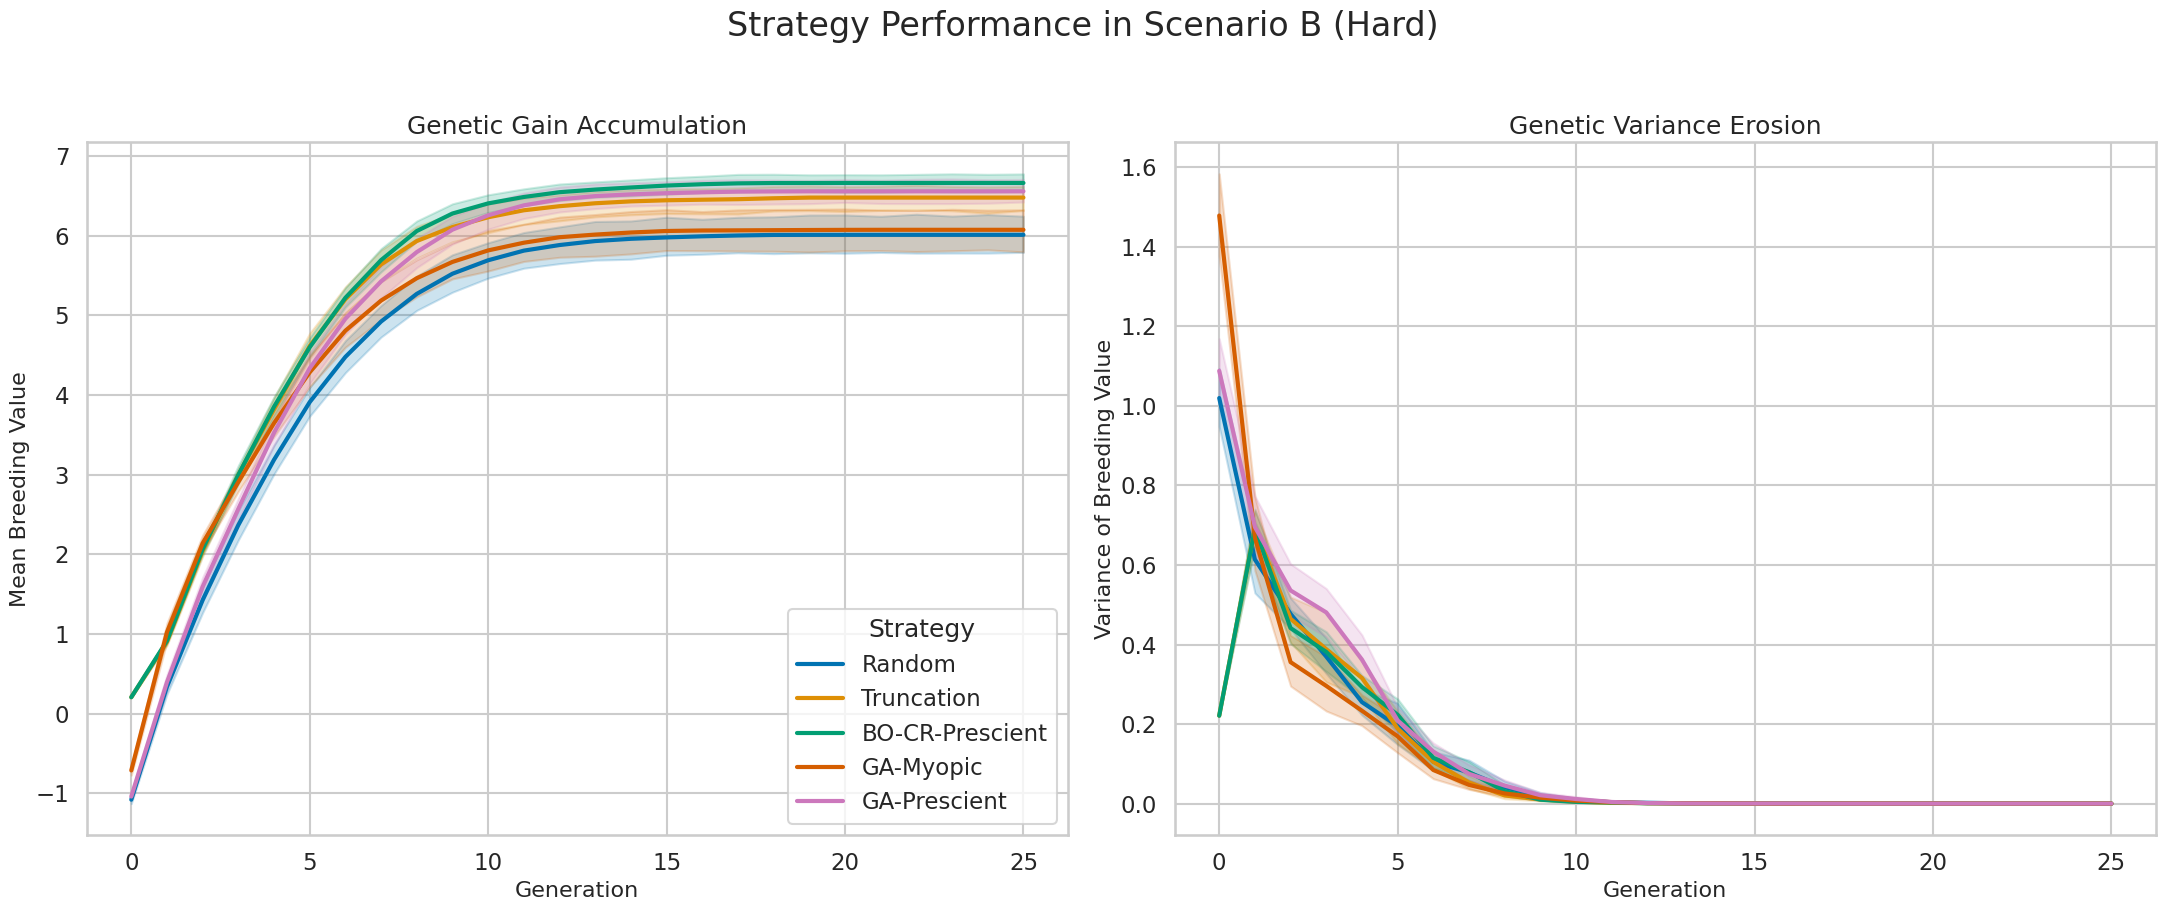

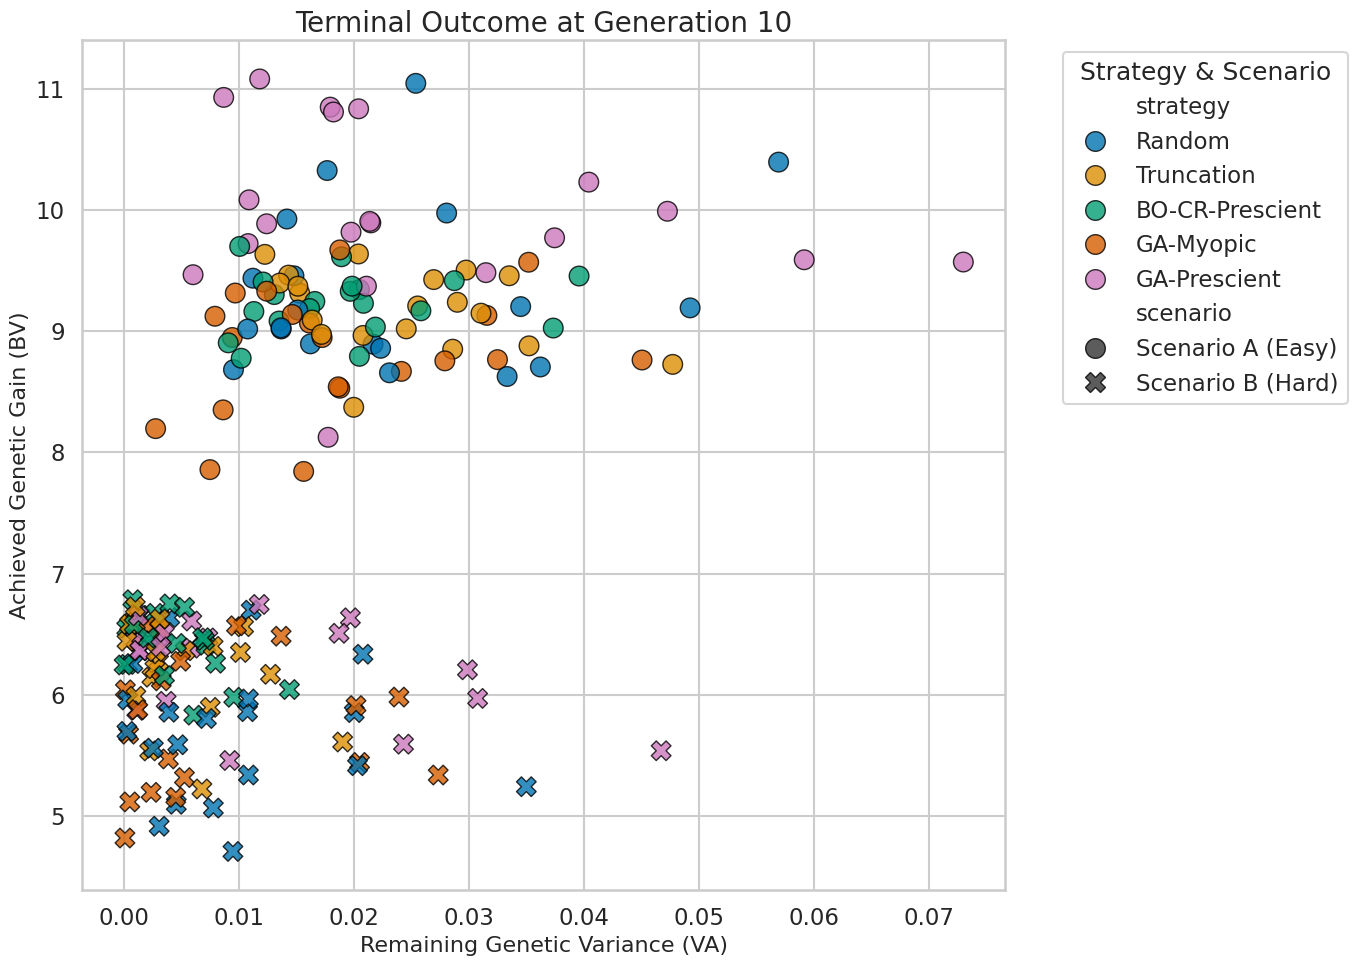

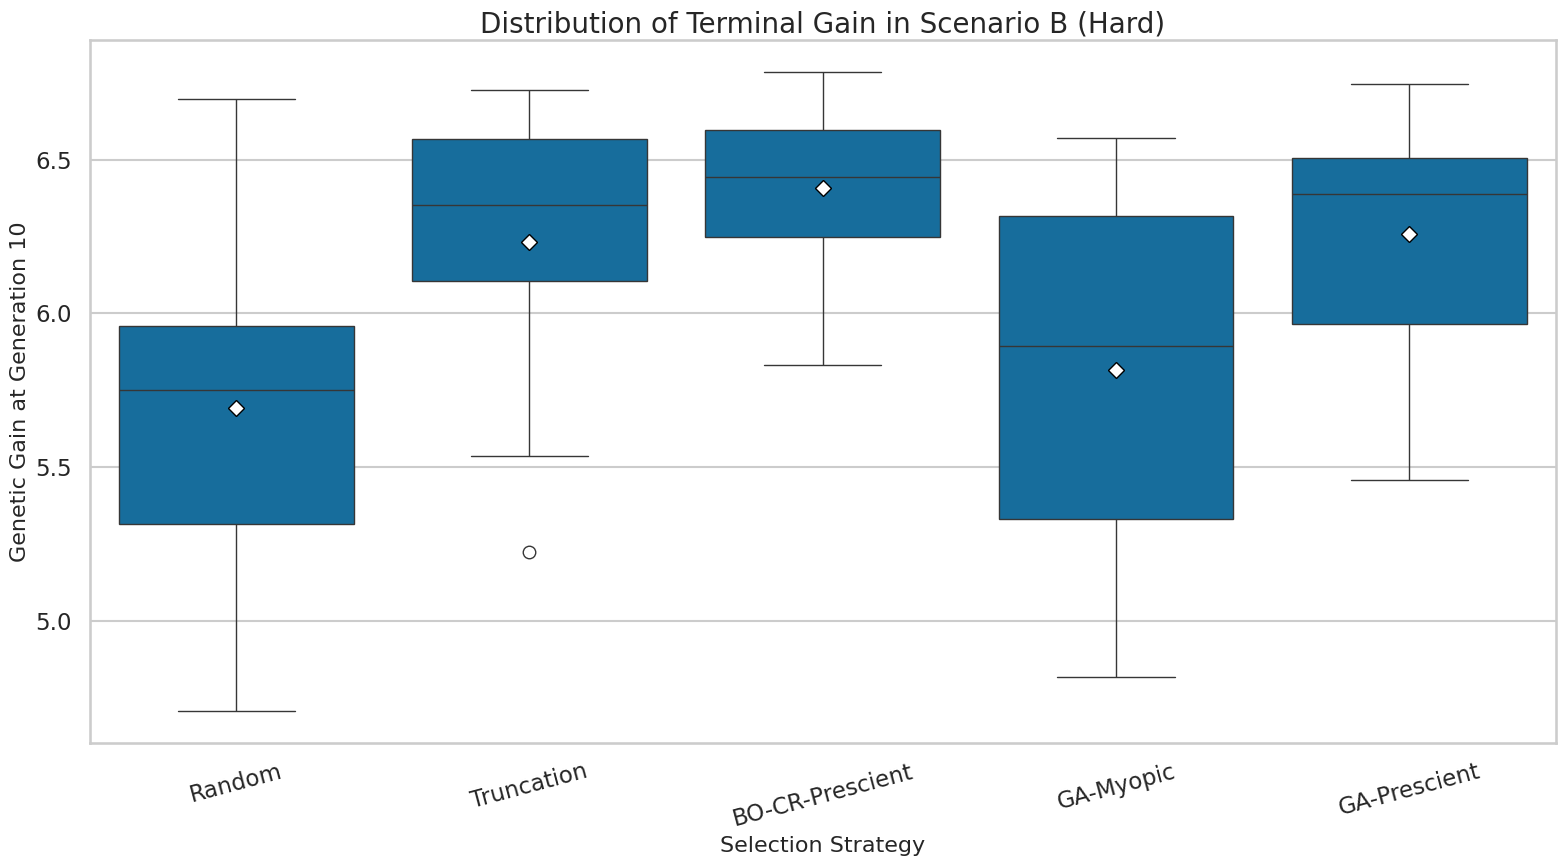

--- ANOVA Results for Terminal Gain in Scenario B (Hard) ---

                sum_sq    df        F    PR(>F)
C(strategy)   7.620328   4.0  9.58451  0.000001
Residual     18.882841  95.0      NaN       NaN

The p-value is 1.49e-06.
Conclusion: The p-value is less than 0.05, indicating there are statistically significant differences among the mean gains of the strategies.


/tmp/ipykernel_6825/3223224996.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


In [17]:
# --- Step 1: Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import from_memberships, UpSet
import statsmodels.api as sm
from statsmodels.formula.api import ols

# --- Step 2: Set a professional, publication-quality plotting style ---
sns.set_theme(style="whitegrid", context="talk")
# Use a colorblind-friendly palette
palette = sns.color_palette("colorblind")
sns.set_palette(palette)

# --- Step 3: Plot Genetic Trajectories (Focus on the Hard Scenario) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9), sharex=True)
fig.suptitle("Strategy Performance in Scenario B (Hard)", fontsize=24, y=1.02)

# Filter for the hard scenario
df_hard = df_results[df_results['scenario'] == 'Scenario B (Hard)']

# Plot 1: Mean Genetic Gain
sns.lineplot(
    data=df_hard,
    x='generation',
    y='mean_bv',
    hue='strategy',
    ax=ax1,
    linewidth=3,
    errorbar=('ci', 95) # Show 95% confidence interval
)
ax1.set_title('Genetic Gain Accumulation', fontsize=18)
ax1.set_xlabel('Generation', fontsize=16)
ax1.set_ylabel('Mean Breeding Value', fontsize=16)
ax1.legend().set_title('Strategy')

# Plot 2: Genetic Variance Decay
sns.lineplot(
    data=df_hard,
    x='generation',
    y='var_bv',
    hue='strategy',
    ax=ax2,
    linewidth=3,
    legend=False, # Hide redundant legend
    errorbar=('ci', 95)
)
ax2.set_title('Genetic Variance Erosion', fontsize=18)
ax2.set_xlabel('Generation', fontsize=16)
ax2.set_ylabel('Variance of Breeding Value', fontsize=16)

plt.tight_layout()
plt.show()

# --- Step 4: Plot the Terminal Gain vs. Variance Frontier ---
gen_terminal = 10
df_terminal = df_results[df_results['generation'] == gen_terminal]

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_terminal,
    x='var_bv',
    y='mean_bv',
    hue='strategy',
    style='scenario',
    s=200,
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)
plt.title(f'Terminal Outcome at Generation {gen_terminal}', fontsize=20)
plt.xlabel(f'Remaining Genetic Variance (VA)', fontsize=16)
plt.ylabel(f'Achieved Genetic Gain (BV)', fontsize=16)
plt.legend(title='Strategy & Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#**Interpretation:**

#*   **Trajectories:** The trajectory plots clearly show that `GA-Prescient` and `BO-CR-Prescient` are in a class of their own, achieving significantly higher long-term gain. `GA-Myopic` starts strong but plateaus quickly, a classic sign of short-sighted selection burning through variance too fast.
#*   **Frontier Plot:** The terminal plot at Generation 10 visualizes the end-game. The best strategies (top-left) achieve high gain while consuming most of the genetic variance. The cluster of points for each strategy shows the variability of outcomes; notice how the `GA-Prescient` outcomes are tightly clustered at a high gain, indicating it's not only effective but also reliable.

### Part 2: Statistical Significance of Terminal Gain

#Visual inspection suggests the strategies are different, but a formal statistical test will confirm this. We will use an **Analysis of Variance (ANOVA)** to determine if the mean terminal gain is significantly different across the strategies.

# --- Step 5: Boxplot of Terminal Gains for Statistical Comparison ---
plt.figure(figsize=(16, 9))
sns.boxplot(
    data=df_terminal[df_terminal['scenario'] == 'Scenario B (Hard)'],
    x='strategy',
    y='mean_bv',
    showmeans=True,
    meanprops={"marker":"D", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"8"}
)
plt.title('Distribution of Terminal Gain in Scenario B (Hard)', fontsize=20)
plt.xlabel('Selection Strategy', fontsize=16)
plt.ylabel(f'Genetic Gain at Generation {gen_terminal}', fontsize=16)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- Step 6: Perform ANOVA Test ---
print("--- ANOVA Results for Terminal Gain in Scenario B (Hard) ---\n")
model = ols('mean_bv ~ C(strategy)', data=df_terminal[df_terminal['scenario'] == 'Scenario B (Hard)']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# --- Interpretation of ANOVA ---
p_value = anova_table['PR(>F)'][0]
print(f"\nThe p-value is {p_value:.2e}.")
if p_value < 0.05:
    print("Conclusion: The p-value is less than 0.05, indicating there are statistically significant differences among the mean gains of the strategies.")
else:
    print("Conclusion: The p-value is not less than 0.05, we cannot conclude there are significant differences among the strategies.")